# IMPORTING LIBRARIES


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# LOADING DATA

In [2]:
import kagglehub
path=kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.
Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
import os, shutil

# Correct path to color images
dataset_dir = os.path.join(path, "plantvillage dataset", "color")

# Create subset folder
subset_dir = "tomato_dataset"
os.makedirs(subset_dir, exist_ok=True)

# Copy only tomato-related folders
for folder in os.listdir(dataset_dir):
    if "Tomato" in folder:
        shutil.copytree(
            os.path.join(dataset_dir, folder),
            os.path.join(subset_dir, folder)
        )

print("Subset created at:", subset_dir)


Subset created at: tomato_dataset


In [4]:
import os

# Show dataset path
print("Dataset path:", path)

# List first level
print("Top-level contents:", os.listdir(path))

# If there is a folder inside, list it too
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"\nContents of {item}:")
        print(os.listdir(item_path)[:10])  # show first 10 items


Dataset path: /kaggle/input/plantvillage-dataset
Top-level contents: ['plantvillage dataset']

Contents of plantvillage dataset:
['segmented', 'grayscale', 'color']


# DATA PREPROCESSING

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 14532 images belonging to 10 classes.
Found 3628 images belonging to 10 classes.


# MODEL BUILDING

In [6]:
# Build simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# TRAINING

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - accuracy: 0.9456 - loss: 0.1593 - val_accuracy: 0.9609 - val_loss: 0.1072
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - accuracy: 0.9520 - loss: 0.1389 - val_accuracy: 0.9512 - val_loss: 0.1547
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.9517 - loss: 0.1417 - val_accuracy: 0.9576 - val_loss: 0.1299
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.9609 - loss: 0.1259 - val_accuracy: 0.9595 - val_loss: 0.1368
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.9566 - loss: 0.1272 - val_accuracy: 0.9672 - val_loss: 0.1086
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - accuracy: 0.9544 - loss: 0.1382 - val_accuracy: 0.9658 - val_loss: 0.1108
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.9604 - loss: 0.1264 - val_accuracy: 0.9595 - val_loss: 0.1092
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 84s 184ms/step - accuracy: 0.9609 - loss: 0

# EVALUATING

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


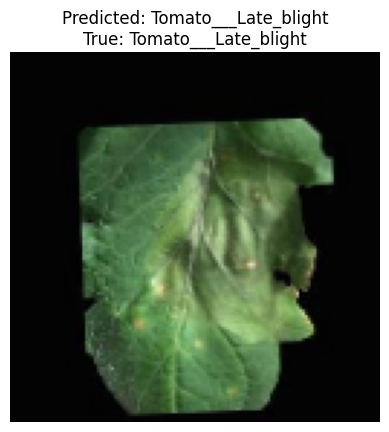

In [18]:
# Get one batch from validation data
images, labels = next(val_gen)

# Pick the first image in the batch
img = images[0]
true_label_index = np.argmax(labels[0])

# Predict
pred = model.predict(np.expand_dims(img, axis=0))  # predict expects a batch
pred_index = np.argmax(pred[0])

# Map index to class name
class_labels = list(val_gen.class_indices.keys())
true_label_name = class_labels[true_label_index]
pred_label_name = class_labels[pred_index]

# Show image and results
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted: {pred_label_name}\nTrue: {true_label_name}")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


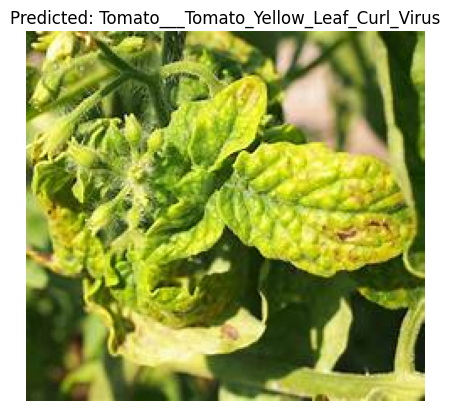

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to your custom image
img_path = "bac.png"

# Load and preprocess
img = image.load_img(img_path, target_size=(128, 128))  # resize to model input size
img_array = image.img_to_array(img) / 255.0             # convert to array + rescale
img_array = np.expand_dims(img_array, axis=0)           # add batch dimension

# Predict
pred = model.predict(img_array)
pred_index = np.argmax(pred[0])

# Map to class name
class_labels = list(val_gen.class_indices.keys())
pred_label_name = class_labels[pred_index]

# Show result
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {pred_label_name}")
plt.axis("off")
plt.show()


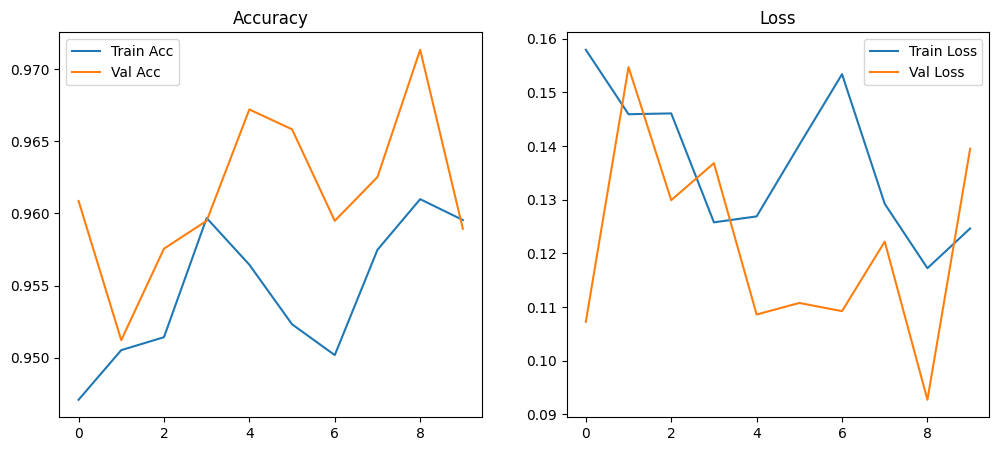

114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step


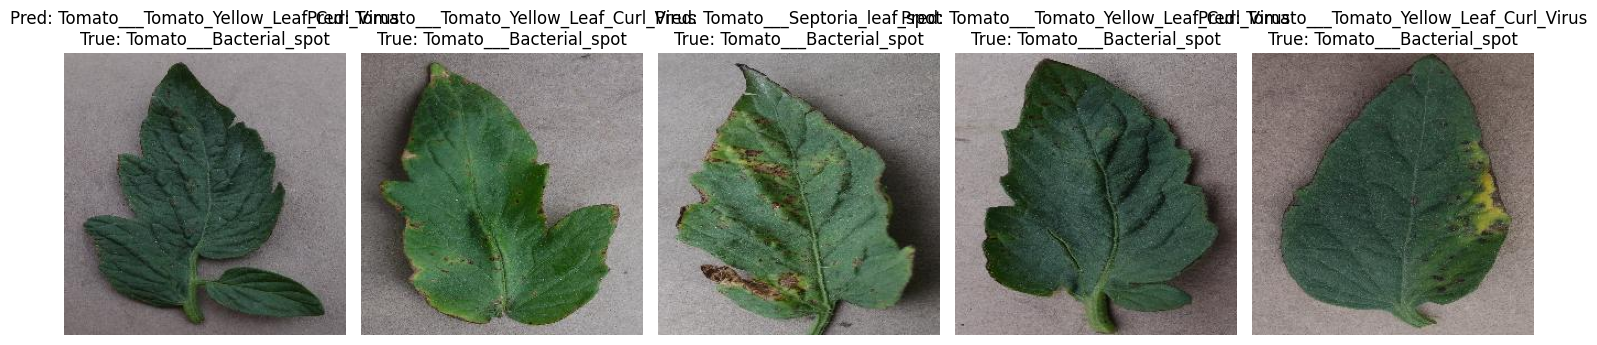

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

# 2. Predictions on validation set
predictions = model.predict(val_gen, verbose=1)
pred_classes = np.argmax(predictions, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Misclassified indices
misclassified_idx = np.where(pred_classes != true_classes)[0]

# 3. Show 5 misclassified images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(misclassified_idx[:5]):
    img_path = val_gen.filepaths[idx]  # get file path of misclassified image

    img = plt.imread(img_path)  # load image from path
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_labels[pred_classes[idx]]}\nTrue: {class_labels[true_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
